# Assignment 1 - Jack Scantlebury

### NOTE: Many figures, plots and animations were generated locally. The more expensive code has been commented out, and the results are stored remotely and displayed as markdown. Tables generated locally have been converted to markdown. The notebook will run on Azure in a reasonable time, but some of the commentary relates to the original benchmarking done locally.

### Introduction

Charged particles create an electric potential in the surrounding space. In $\mathbb{R}^2$, the potential created at $\overrightarrow p$ by $N$ particles at positions $\overrightarrow{p}_j$ with charges $k_j$ is:
$$
\begin{align}
    V(\overrightarrow{p}) &= -\sum_{j=1}^N k_j \ln{\left|\left|\overrightarrow{p} - \overrightarrow{p}_j\right|\right|_2} \\
    \text{where} \quad \overrightarrow{p} &= \begin{bmatrix}
        x\\
        y
    \end{bmatrix}
\end{align}
$$

Given a [0, 1] space in $\mathbb{R}^2$ with charges placed somewhere in that space, we can discretise into an $M \times M$ grid, and calculate the potential at each point.

### Code: Part I

The constructor of the ```PotentialGrid``` class takes many (mostly optional) parameters. Some of the more important ones are:


| Parameter(=default)     | Description   |
|:-------------:|:-------------|
| N     | Number of particles |
| grid_pts      | Grid points per dimension      |
| k_arr=-1 | List of charge values      |
| pos_arr=-1 | List of particle positions      |
| circle=False | True: Arrange particles in circle of radius 0.3, False: Random particle distribution |
| dtype='float32' | Precision. Can be 'float32' (C: float) or 'float64' (C: double) |
| opencl=True | Use OpenCL or Python (Numpy) |
| parallel=True | (Requires opencl=True) True: Use parallel kernel, False: Use 'in series' kernel |
| random_charges=False | True: Each charge has 50% chance of being +/-. False: All charges + |


If the charges and positions of the particles are left unspecified, all charges are set to +/- 1 (```random_charges=True```) or + 1 (```random_charges=False```), with positions are determined by the ```circle``` flag.

The class method ```calculate_potential_grid()``` is used to calculate the potentials at the grid points which are stored in the class variable ```grid_array```. The ```opencl``` and ```parallel``` flags in the constructor control how the potentials are calculated; ```opencl=False``` will force the use of numpy, ```opencl=True``` with ```parallel=False``` will force the use of the OpenCL kernel that uses nested for loops and ```parallel=True``` causes the class to use OpenCL with parallelism.

The parallel kernel uses a different thread and global ID for each grid point, which is extremely efficient because the number of grid points (usually) far exceeds the number of particles $N$ (comparisons can be found below the class code).

### Code: Part II

The force acting on a particle is proportional to the gradient of the potential:

$$
\begin{align}
    \overrightarrow{F}(\overrightarrow{p}_i) &= -k_i\sum^{N-1}_{j=0, j\neq i} \nabla V(\overrightarrow{p}_j)\\
    &= \sum^{N-1}_{j=0, j\neq i} k_ik_j \nabla \ln{\left|\left|\overrightarrow{p}_i - \overrightarrow{p}_j\right|\right|_2}\\
    &= \sum^{N-1}_{j=0, j\neq i} k_ik_j \nabla \ln{\sqrt{(x_i - x_j)^2 + (y_i - y_j)^2}}\\
    &= \frac{1}{2} \sum^{N-1}_{j=0, j\neq i} k_ik_j \nabla \ln{\left[(x_i - x_j)^2 + (y_i - y_j)^2\right]}\\
    &= \frac{1}{2} \sum^{N-1}_{j=0, j\neq i} k_ik_j \cdot \begin{pmatrix}
        \frac{\partial d}{\partial x_i} \ln{\left[(x_i - x_j)^2 + (y_i - y_j)^2\right]} \\
        \frac{\partial d}{\partial y_i} \ln{\left[(x_i - x_j)^2 + (y_i - y_j)^2\right]}
    \end{pmatrix}\\
    &= \frac{1}{2} \sum^{N-1}_{j=0, j\neq i} \frac{k_ik_j}{(x_i - x_j)^2 + (y_i - y_j)^2} \cdot \begin{pmatrix}
        2(x_i - x_j) \\
        2(y_i - y_j)
    \end{pmatrix} \\
    &= \sum^{N-1}_{j=0, j\neq i} \frac{k_ik_j}{(x_i - x_j)^2 + (y_i - y_j)^2} \cdot \begin{pmatrix}
        (x_i - x_j) \\
        (y_i - y_j)
    \end{pmatrix}
\end{align}
$$

The force acting in the $x$ and $y$ directions are independent and can be calculated separately. The forces can be used to calculate the velocities $\overrightarrow{v}_i$ and therefore the particle positions at each timestep $n$:

$$
\begin{align}
    \overrightarrow{p}_i^{(n+1)} &= \overrightarrow{p}_i^{(n)} + \Delta t \overrightarrow{v}_i^{(n+1/2)} \\
    \overrightarrow{v}_i^{(n+3/2)} &= \overrightarrow{v}_i^{(n+1/2)} + \Delta t \overrightarrow{F}\left(\overrightarrow{p}_i^{(n)}\right)   
\end{align}
$$

Given $\overrightarrow{v}_i^{(0)}$ and $\overrightarrow{p}_i^{(0)}$, we must find $\overrightarrow{v}_i^{(1/2)}$. To this end, we can do one Forward Euler step:

$$
\begin{align}
    \overrightarrow{v}_i^{(1/2)} &= \overrightarrow{v}_i^{(0)} + \frac{1}{2} \Delta t \overrightarrow{F}\left(\overrightarrow{p}_i^{(0)}\right)
\end{align}
$$

We now have a viable algorithm. In the code below, there are again options for using numpy and OpenCL, in series and in parallel. However, the speed gain from parallelisation here is far smaller than for calculating the potentials, because there is one thread per particle rather than per grid point. Within each thread, there is still a substantial for loop in the calculation of the electrostatic force felt by the particle.

The ```move()``` method uses two kernels. The first calculates all of the forces by the above formula, then the new positions of the particles given their velocities, then the new particle velocities given the calculated forces and timestep specified in the function call. The second is ```calculate_potential_grid()```, which recalculates the potential under the new particle positions.

Speed tests and plots can be found below the main code.

In [1]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import rc
from mako.template import Template
from IPython.display import HTML

import matplotlib.animation as animation
import numpy as np
import pyopencl as cl
import random
import time
import os
import sys

#os.environ['PYOPENCL_COMPILER_OUTPUT'] = '1'

In [25]:
HTML("""
<div align="middle">
<video width="80%" controls autoplay loop>
	<source src="https://i.imgur.com/LnjdXNu.mp4" type="video/mp4">
</video></div>
""")

In [2]:
class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

In [13]:
class PotentialGrid(object):
    
    dtype = -1
    ctype = -1
    grid_arr = np.zeros((1,1))
    N = -1
    k_arr = -1
    pos_arr = -1
    grid_pts = -1
    grid_pos = []
    opencl=-1
    parallel=-1
    pparallel=-1
    startup_time=-1
    device_id=-1
    forces=-1
    v0=-1
    lims=[0, 1]
    opencl=-1
    parallel=-1
    im=-1
    vhalf=-1
    max_pot=1
    move_times=[]
    random_charges=-1
    
    # Generate an array of n points that form a circle of radius r
    def pts_circle(self, n, r, centre=[0,0]):
        result = []
        deg = 2*np.pi/n
        result = []
        for idx in range(n):
            x = r*np.sin(deg*idx) + centre[0]
            y = r*np.cos(deg*idx) + centre[1]
            result.append([x, y])
        return result
    
    def calculate_potential_grid(self):
        with Timer() as t:
            spacing = 1/self.grid_pts
            if not self.opencl:
                for row, _ in enumerate(self.grid_arr):
                    for col, value in enumerate(_):
                        x = col*spacing
                        y = row*spacing
                        potential = 0.0
                        for j in range(self.N):
                            xdiff = x - self.pos_arr[j][0]
                            ydiff = y - self.pos_arr[j][1]
                            if xdiff == 0 and ydiff == 0:
                                pass
                            else:
                                dist = np.linalg.norm(np.array([xdiff, ydiff]).astype(self.dtype), 2)
                                potential -= self.k_arr[j]*np.log(dist)
                        self.grid_arr[row, col] = potential
            else:
                ctx = cl.create_some_context()
                mf = cl.mem_flags

                particle_x=self.pos_arr[:, 0].astype(self.dtype)
                particle_y=self.pos_arr[:, 1].astype(self.dtype)
                particle_k=self.k_arr.astype(self.dtype)
                other_info=np.array([self.grid_pts, self.N]).astype('int32')
                queue = cl.CommandQueue(ctx)
                
                x_arr = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR,
                                       hostbuf=particle_x)
                y_arr= cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR,
                                       hostbuf=particle_y)
                k_arr= cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR,
                                       hostbuf=particle_k)
                info = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR,
                                       hostbuf=other_info)
                if self.parallel:
                    kernel_template=Template("""
                        
                        ${ctype} norm(${ctype} x1, ${ctype} y1, ${ctype} x2, ${ctype} y2){
                            ${ctype} xdiff = x1 - x2;
                            ${ctype} ydiff = y1 - y2;
                            ${ctype} norm = sqrt(xdiff*xdiff + ydiff*ydiff);
                            return norm;
                        }
                        
                        __kernel void potential(__global const ${ctype} *x_arr,
                                          __global ${ctype} *y_arr, __global ${ctype} *k_arr,
                                          __global int *info, __global ${ctype} *potentials){
                                
                                const int idx = get_global_id(0);
                
                                const int npoints = info[0];
                                const ${ctype} spacing = 1/(${ctype})(info[0]);
                                
                                const ${ctype} y_pos = spacing*idx / npoints;
                                const ${ctype} x_pos = spacing*(idx % npoints);
                                
                                const int N = info[1];
                                
                                ${ctype} acc = 0.0;
                                
                                for(int j = 0; j < N; j++){
                                    ${ctype} n = norm(x_pos, y_pos, x_arr[j], y_arr[j]);
                                    acc = acc - k_arr[j]*log(n);
                                }
                                
                                potentials[idx] = acc;
                                
                            }
                        """)
                else:
                    kernel_template=Template("""
                        
                        //For calculation of the 2-norm between two points
                        ${ctype} norm(${ctype} x1, ${ctype} y1, ${ctype} x2, ${ctype} y2){
                            ${ctype} xdiff = x1 - x2;
                            ${ctype} ydiff = y1 - y2;
                            ${ctype} norm = sqrt(xdiff*xdiff + ydiff*ydiff);
                            return norm;
                        }
                        
                        __kernel void potential(__global const ${ctype} *x_arr,
                                          __global ${ctype} *y_arr, __global ${ctype} *k_arr,
                                          __global int *info, __global ${ctype} *potentials){
                        
                                const int npoints = info[0];
                                const ${ctype} spacing = 1/(${ctype})(info[0]);
                                
                                const int N = info[1];
                                
                                const int len = npoints*npoints;
                                
                                for(int idx=0; idx<len; idx++){
                                    const ${ctype} y_pos = spacing*idx / npoints;
                                    const ${ctype} x_pos = spacing*(idx % npoints);
    
                                    ${ctype} acc = 0.0;
                                    for(int j = 0; j < N; j++){
                                        ${ctype} n = norm(x_pos, y_pos, x_arr[j], y_arr[j]);
                                        acc = acc - k_arr[j]*log(n);
                                    }
                                    potentials[idx] = acc;
                                }
                            }
                        """)
                kernel = kernel_template.render(ctype=self.ctype) # Templating
                prg = cl.Program(ctx, kernel).build()
                
                size_array = np.zeros((self.grid_pts**2, 1), dtype=self.dtype)
                potential_buffer = cl.Buffer(ctx, mf.WRITE_ONLY, size_array.nbytes)
                if self.parallel:
                    prg.potential(queue, (self.grid_pts**2, ), None, x_arr, y_arr,
                                  k_arr, info, potential_buffer)
                else:
                    prg.potential(queue, (1, ), None, x_arr, y_arr,
                                  k_arr, info, potential_buffer)
                self.grid_arr = np.zeros((self.grid_pts**2), dtype=self.dtype)
                cl.enqueue_copy(queue, self.grid_arr, potential_buffer)
                self.grid_arr = self.grid_arr.reshape(self.grid_pts, self.grid_pts)
        self.startup_time = t.interval
        return self.grid_arr
    
    def __init__(self, N, grid_pts, k_arr=-1, pos_arr=-1, circle=False, dtype='float32',
                 opencl=True, parallel=True, device_id=0, v0=-1, random_charges=False):
        with Timer() as t:
            self.dtype = dtype
            self.grid_arr = np.zeros((grid_pts, grid_pts), dtype=self.dtype)
            self.grid_pos = self.grid_arr
            self.grid_pts = grid_pts
            self.opencl=opencl
            self.parallel=parallel
            self.N=N
            self.device_id=device_id
            self.forces = np.zeros((N, 2)).astype(dtype)
            self.opencl=opencl
            self.parallel=parallel
            self.dtype=dtype
            self.random_charges=random_charges
            if v0==-1:
                self.v0=np.zeros((N, 2)).astype(dtype)
            if dtype == 'float32':
                self.ctype = 'float'
            else:
                self.ctype = 'double'
            if circle:
                self.k_arr = 1*np.ones((N, 1)).astype(dtype)
                if self.random_charges:
                    for idx, i in enumerate(self.k_arr):
                        if random.uniform(0, 1) > 0.5:
                            self.k_arr[idx] = -self.k_arr[idx]
                self.pos_arr = np.array(self.pts_circle(N, 0.3, [0.5, 0.5]))
            elif k_arr == -1 and pos_arr == -1:
                k = []
                pos = []
                for j in range(N):
                    pos_pt = np.array([random.uniform(0, 1), random.uniform(0, 1)])
                    pos.append(pos_pt)
                    #k.append(random.uniform(0, 1)) # RANDOM CHARGE STRENGTHS
                    if random.uniform(0, 1) < 0.5 or not random_charges:
                        k.append(1)
                    else:
                        k.append(-1)
                self.k_arr = np.array(k).astype(dtype)
                self.pos_arr = np.array(pos).astype(dtype)
                for idx, i in enumerate(self.k_arr):
                    if random.uniform(0,1) > 0.5:
                        self.k_arr[idx] = -self.k_arr[idx]
            else:
                self.pos_arr = np.zeros((len(pos_arr), 2))
                for i in range(len(self.pos_arr)):
                    self.pos_arr[i, 0] = pos_arr[i][0]
                    self.pos_arr[i, 1] = pos_arr[i][1]
                self.k_arr = np.array(k_arr).reshape(len(k_arr), 1)
            self.calculate_potential_grid()
        self.startup_time = t.interval
        
    #opencl=False
    def calculate_force(self, pt, k_pt, x, y, k, n):
        Fx = 0.0
        Fy = 0.0
        for j in range(len(x)):
            if j != n:
                premul = k_pt*k[j]/((pt[0] - x[j])**2 + (pt[1] - y[j])**2)
                Fx += (pt[0] - x[j])*premul
                Fy += (pt[1] - y[j])*premul
        result = np.zeros((1, 2))
        result[0, 0] = Fx
        result[0, 1] = Fy
        return result
    
    #opencl=False
    def all_forces(self):
        for item in range(len(self.k_arr)):
            self.forces[item, :] = self.calculate_force(self.pos_arr[item],
                                                        self.k_arr[item],
                                                   self.pos_arr[:, 0],
                                                   self.pos_arr[:, 1],
                                                   self.k_arr, item)
    def move(self, delta_t, opencl, parallel, pparallel):
        if not opencl: # Use Python
            self.all_forces()
            if type(self.vhalf) == int:
                self.vhalf = 0.5*delta_t*self.forces
            self.pos_arr = self.pos_arr + delta_t*self.vhalf
            self.vhalf = self.vhalf + delta_t*self.forces
        else: #Use OpenCL
            ctx = cl.create_some_context()
            mf = cl.mem_flags

            vhalf_zero_flag = -1
            if type(self.vhalf) == int and (not parallel or not pparallel):
                vhalf_zero_flag = 1
                self.vhalf=np.zeros((self.N, 2))
            spacing = 1/self.grid_pts
            particle_x=self.pos_arr[:, 0].astype(self.dtype)
            particle_y=self.pos_arr[:, 1].astype(self.dtype)
            particle_k=self.k_arr.astype(self.dtype)
            if type(self.vhalf) != int:
                particle_vx=self.vhalf[:, 0].astype(self.dtype)
                particle_vy=self.vhalf[:, 1].astype(self.dtype)
                vx_arr = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR,
                                   hostbuf=particle_vx)
                vy_arr = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR,
                                   hostbuf=particle_vy)
            other_info=np.array([self.grid_pts, self.N, delta_t, vhalf_zero_flag]).astype(self.dtype)
            platform = cl.get_platforms()
            my_gpu_devices = platform[self.device_id].get_devices(device_type=cl.device_type.GPU)
            queue = cl.CommandQueue(ctx)

            x_arr = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR,
                                   hostbuf=particle_x)
            y_arr = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR,
                                   hostbuf=particle_y)
            k_arr = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                                   hostbuf=particle_k)

            info = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                                   hostbuf=other_info)

            if parallel and not pparallel:
                kernel_template=Template("""

                    //For calculation of the 2-norm between two points
                    ${ctype} norm(${ctype} x1, ${ctype} y1, ${ctype} x2, ${ctype} y2){
                        ${ctype} xdiff = x1 - x2;
                        ${ctype} ydiff = y1 - y2;
                        ${ctype} norm = sqrt(xdiff*xdiff + ydiff*ydiff);
                        return norm;
                    }

                    __kernel void move(__global ${ctype} *x_arr,
                                      __global ${ctype} *y_arr, __global ${ctype} const *k_arr,
                                      __global ${ctype} *vx_arr, __global ${ctype} *vy_arr,
                                      __global ${ctype} const *info,
                                      __global ${ctype} *Fx, __global ${ctype} *Fy){

                            const int global_id = get_global_id(0);

                            const int npoints = (int)info[0];
                            const int N = (int)info[1];
                            const ${ctype} dt = (${ctype})info[2];
                            const ${ctype} spacing = 1/(${ctype})(info[0]);
                            const int len = npoints*npoints;

                            ${ctype} fx = 0;
                            ${ctype} fy = 0;
                            ${ctype} x1 = x_arr[global_id];
                            ${ctype} y1 = y_arr[global_id];
                            ${ctype} k_pt = k_arr[global_id];

                            for(int j=0; j<N; j++){
                                const ${ctype} x2 = x_arr[j];
                                const ${ctype} y2 = y_arr[j];
                                if(j != global_id){ // No self-interaction
                                    const ${ctype} premul = k_pt*k_arr[j]/((x1 - x2)*(x1 - x2) + (y1 - y2)*(y1 - y2));
                                    fx = fx + (x1 - x2)*premul;
                                    fy = fy + (y1 - y2)*premul;
                                }
                            }

                            Fx[global_id] = fx;
                            Fy[global_id] = fy;

                            if(info[3] > 0){
                                vx_arr[global_id] = 0.5*dt*Fx[global_id];
                                vy_arr[global_id] = 0.5*dt*Fy[global_id];
                            }

                            x_arr[global_id] = x_arr[global_id] + dt*vx_arr[global_id];
                            y_arr[global_id] = y_arr[global_id] + dt*vy_arr[global_id];
                            vx_arr[global_id] = vx_arr[global_id] + dt*Fx[global_id];
                            vy_arr[global_id] = vy_arr[global_id] + dt*Fy[global_id];
                        }
                    """)
            elif parallel and pparallel:
                kernel_template=Template("""

                    //For calculation of the 2-norm between two points
                    ${ctype} norm(${ctype} x1, ${ctype} y1, ${ctype} x2, ${ctype} y2){
                        ${ctype} xdiff = x1 - x2;
                        ${ctype} ydiff = y1 - y2;
                        ${ctype} norm = sqrt(xdiff*xdiff + ydiff*ydiff);
                        return norm;
                    }

                    __kernel void move(__global ${ctype} *x_arr,
                                      __global ${ctype} *y_arr, __global ${ctype} const *k_arr,
                                      __global ${ctype} const *info,
                                      __global ${ctype} *Fx, __global ${ctype} *Fy){

                            const int row = get_global_id(0);
                            const int col = get_global_id(1);
                            const int N = (int)info[1];

                            ${ctype} fx = 0;
                            ${ctype} fy = 0;
                            if(col != row){ // No self-interaction

                                const ${ctype} x1 = x_arr[row];
                                const ${ctype} y1 = y_arr[row];
                                const ${ctype} k1 = k_arr[row];
                                const ${ctype} x2 = x_arr[col];
                                const ${ctype} y2 = y_arr[col];
                                const ${ctype} k2 = k_arr[col];

                                const ${ctype} premul = k1*k2/((x1 - x2)*(x1 - x2) + (y1 - y2)*(y1 - y2));
                                fx = -(x1 - x2)*premul;
                                fy = -(y1 - y2)*premul;
                                Fx[row*N + col] = fx;
                                Fy[row*N + col] = fy;
                            } else {
                                Fx[row*N + col] = 0;
                                Fy[row*N + col] = 0;
                            }
                        }
                    """)
            else: #Single thread with nested for loops
                kernel_template=Template("""

                    //For calculation of the 2-norm between two points
                    ${ctype} norm(${ctype} x1, ${ctype} y1, ${ctype} x2, ${ctype} y2){
                        ${ctype} xdiff = x1 - x2;
                        ${ctype} ydiff = y1 - y2;
                        ${ctype} norm = sqrt(xdiff*xdiff + ydiff*ydiff);
                        return norm;
                    }

                    __kernel void move(__global ${ctype} *x_arr,
                                      __global ${ctype} *y_arr, __global ${ctype} const *k_arr,
                                      __global ${ctype} *vx_arr, __global ${ctype} *vy_arr,
                                      __global ${ctype} const *info,
                                      __global ${ctype} *Fx, __global ${ctype} *Fy){

                            const int npoints = (int)info[0];
                            const int N = (int)info[1];
                            const ${ctype} dt = (${ctype})info[2];
                            const ${ctype} spacing = 1/(${ctype})(info[0]);
                            const int len = npoints*npoints;

                            for(int n=0; n<N; n++){
                                ${ctype} fx = 0;
                                ${ctype} fy = 0;
                                ${ctype} x1 = x_arr[n];
                                ${ctype} y1 = y_arr[n];
                                ${ctype} k_pt = k_arr[n];
                                for(int j=0; j<N; j++){
                                    const ${ctype} x2 = x_arr[j];
                                    const ${ctype} y2 = y_arr[j];
                                    if(j != n){ // No self-interaction
                                        const ${ctype} premul = k_pt*k_arr[j]/((x1 - x2)*(x1 - x2) + (y1 - y2)*(y1 - y2));
                                        fx = (x1 - x2)*premul;
                                        fy = (y1 - y2)*premul;
                                    }
                                }
                                Fx[n] = fx;
                                Fy[n] = fy;
                            }

                            if(info[3] > 0){
                                for(int idx=0; idx<N; idx++){
                                    vx_arr[idx] = 0.5*dt*Fx[idx];
                                    vy_arr[idx] = 0.5*dt*Fy[idx];
                                }
                            }

                            for(int idx=0; idx<N; idx++){
                                x_arr[idx] = x_arr[idx] + dt*vx_arr[idx];
                                y_arr[idx] = y_arr[idx] + dt*vy_arr[idx];
                            }

                            for(int idx=0; idx<N; idx++){
                                vx_arr[idx] = vx_arr[idx] + dt*Fx[idx];
                                vy_arr[idx] = vy_arr[idx] + dt*Fy[idx];
                            }
                        }
                    """)
            kernel = kernel_template.render(ctype=self.ctype, len=str(self.N)) # Templating
            prg = cl.Program(ctx, kernel).build()

            size_array = np.zeros((self.N, 1), dtype=self.dtype)
            if not pparallel:
                fx_buffer = cl.Buffer(ctx, mf.WRITE_ONLY, size_array.nbytes)
                fy_buffer = cl.Buffer(ctx, mf.WRITE_ONLY, size_array.nbytes)
            else:
                fx_grid_size_array = np.zeros((self.N**2, 1), dtype=self.dtype)
                fy_grid_size_array = np.zeros((self.N**2, 1), dtype=self.dtype)
                fx_buffer = cl.Buffer(ctx, mf.WRITE_ONLY, fx_grid_size_array.nbytes)
                fy_buffer = cl.Buffer(ctx, mf.WRITE_ONLY, fy_grid_size_array.nbytes)

            if parallel and not pparallel:
                prg.move(queue, (self.N, ), (1, ), x_arr, y_arr, k_arr, vx_arr, vy_arr, info,
                        fx_buffer, fy_buffer)
            elif parallel and pparallel:
                prg.move(queue, (self.N, self.N), None, x_arr, y_arr, k_arr, info,
                        fx_buffer, fy_buffer)
            else:
                prg.move(queue, (1, ), None, x_arr, y_arr, k_arr, vx_arr, vy_arr, info,
                         fx_buffer, fy_buffer)                    
            if (not parallel) or (parallel and not pparallel):
                vx = np.empty_like(self.vhalf[:, 0]).astype(self.dtype)
                vy = np.empty_like(self.vhalf[:, 0]).astype(self.dtype)
                x = np.empty_like(self.pos_arr[:, 0]).astype(self.dtype)
                y = np.empty_like(self.pos_arr[:, 0]).astype(self.dtype)
                cl.enqueue_copy(queue, x, x_arr)
                cl.enqueue_copy(queue, y, y_arr)
                cl.enqueue_copy(queue, vx, vx_arr)
                cl.enqueue_copy(queue, vy, vy_arr)
                self.pos_arr[:, 0] = x
                self.pos_arr[:, 1] = y
                self.vhalf[:, 0] = vx
                self.vhalf[:, 1] = vy
            else:
                cl.enqueue_copy(queue, fx_grid_size_array, fx_buffer)
                cl.enqueue_copy(queue, fy_grid_size_array, fy_buffer)

                fx_grid_size_array = fx_grid_size_array.reshape(self.N, self.N)
                fy_grid_size_array = fy_grid_size_array.reshape(self.N, self.N)
                for n in range(self.N):
                    self.forces[n, 0] = np.sum(fx_grid_size_array[:, n])
                    self.forces[n, 1] = np.sum(fy_grid_size_array[:, n])
                if type(self.vhalf) == int:
                    self.vhalf = self.v0 + 0.5*delta_t*self.forces
                self.pos_arr = self.pos_arr + delta_t*self.vhalf
                self.vhalf = self.vhalf + delta_t*self.forces

                #print(self.pos_arr)
                #print('Forces\n', self.forces)
                #print('Velocities\n', self.vhalf)
                #print('Charges\n', self.k_arr)
        self.calculate_potential_grid()
        
    @property
    def grid(self):
        return self.grid_arr
    
    def potential_at(self, x, y):
        return self.grid_arr[x, y]

    def show_potential(self, plot_charges=True):
        plt.clf()
        fig, ax = plt.subplots(figsize=(10, 10))
        if self.random_charges:
            plt.imshow(self.grid_arr/np.amax(self.grid_arr), cmap='bwr'
                       )      #cmap='gray'   
        else:
            plt.imshow(self.grid_arr/np.amax(self.grid_arr), cmap='gray'
                       )      #cmap='gray'   
        max_k = np.amax(self.k_arr)
        if plot_charges:
            for idx, point in enumerate(self.pos_arr):
                size = 5*self.k_arr[idx]/max_k
                plt.plot(point[0]*self.grid_pts, point[1]*self.grid_pts, 'w-+',
                         markersize=size)
        
        ax.yaxis.set_major_locator(plt.NullLocator())
        ax.xaxis.set_major_formatter(plt.NullFormatter())
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(r'$x$')
        plt.ylabel(r'$y$')
        cps = (self.N*self.grid_pts**2)/self.startup_time
        cbar = plt.colorbar()
        cbar.set_label('Charge',size=18)
        if self.opencl:
            if self.parallel:
                titlestr = ('N = ' + str(len(self.k_arr)) + ' | Grid Points = '
                            + str(self.grid_pts) + '\nOpenCL | Parallel' + '\n' +
                            '%.3e' % cps + ' calculations per second')
            else:
                titlestr = ('N = ' + str(len(self.k_arr)) +
                            ' | Grid Points = ' + str(self.grid_pts) +
                            '\nOpanCL | Non-Parallel' + '\n' + '%.3e' % cps +
                            ' calculations/s')
        else:            
            titlestr = ('N = ' + str(len(self.k_arr)) + ' | Grid Points = ' +
                        str(self.grid_pts) + '\nPython' + '\n' + '%.3e' % cps +
                        ' calculations/s')
        plt.title(titlestr)
        plt.show()

## Results: Part I

### Plots: Part I

The ```show_potential()``` method uses ```matplotlib``` to visualise the current potential at each grid point:

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


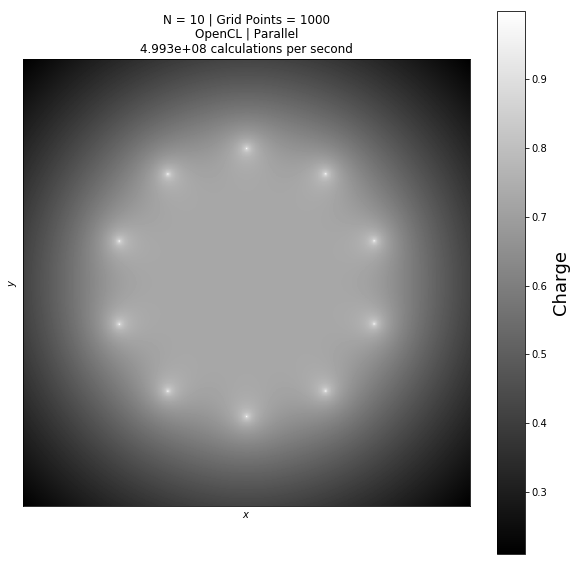

In [16]:
grid_1 = PotentialGrid(10, 400, dtype='float32', circle=True, opencl=True,
                     parallel=True, random_charges=False)

grid_1.show_potential(plot_charges=False)

The calculations per second is shown above the plot. The time taken to calculate the potentials on the entire grid is recorded in the class variable ```startup_time```. The calculations per second $c$ is taken to be:

$$
\begin{align}
    c = \frac{Nm^2}{t}
\end{align}
$$

where $N$ is the number of particles, $m$ is the grid points per dimension and $t$ is the calculation time in seconds. We can see an enormous difference between the different calculation methods (Python, OpenCL, (non)-parallel):

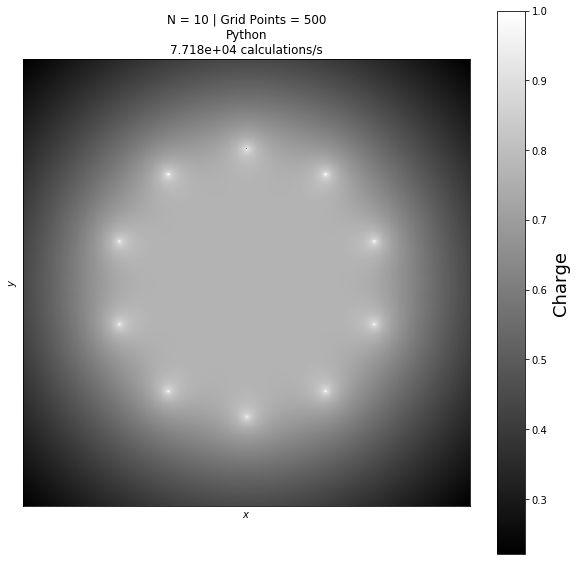

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x2620cfad6b0> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)


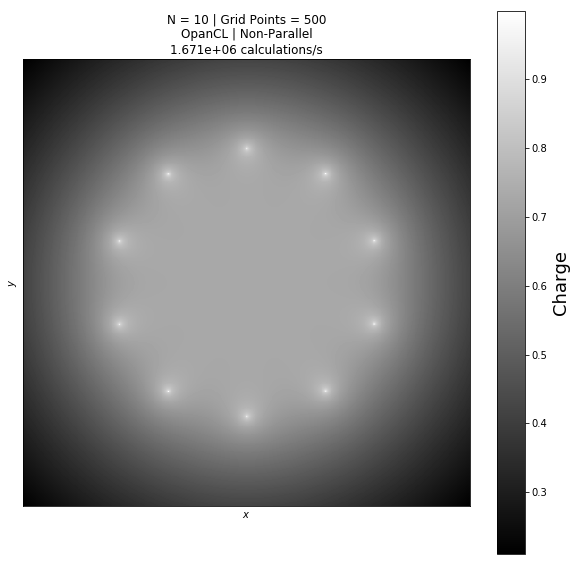

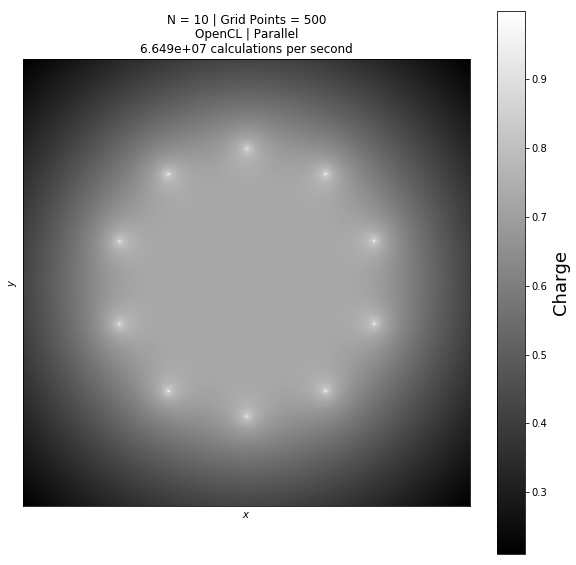

In [5]:
grid_python = PotentialGrid(10, 400, dtype='float32', circle=True, opencl=False,
                     parallel=False, random_charges=False)
grid_python.show_potential(plot_charges=False)

grid_cl_series = PotentialGrid(10, 400, dtype='float32', circle=True, opencl=True,
                     parallel=False, random_charges=False)
grid_cl_series.show_potential(plot_charges=False)

grid_cl_parallel = PotentialGrid(10, 400, dtype='float32', circle=True, opencl=True,
                     parallel=True, random_charges=False)
grid_cl_parallel.show_potential(plot_charges=False)

We can also change the type to double precision:

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x2620cfad6b0> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)


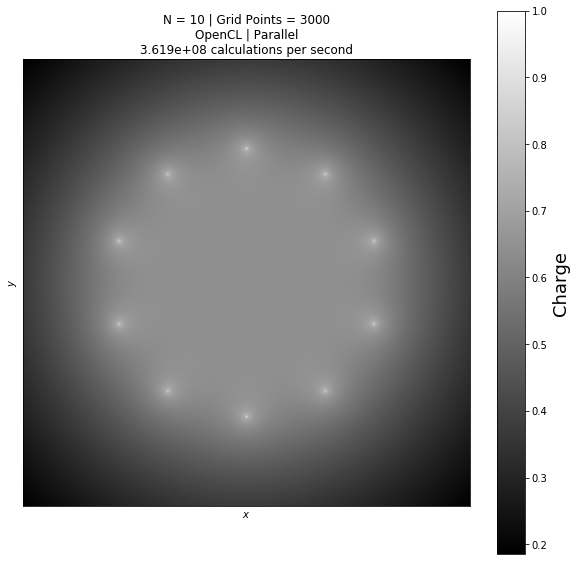

In [6]:
grid_double = PotentialGrid(10, 3000, dtype='float64', circle=True, opencl=True,
                     parallel=True, random_charges=False)
grid_double.show_potential(plot_charges=False)

We can randomise the particle positions, the sign of their charges and change the number of charges (the colour scheme changes to better show both positive and negative charge):

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x2620cfad6b0> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)


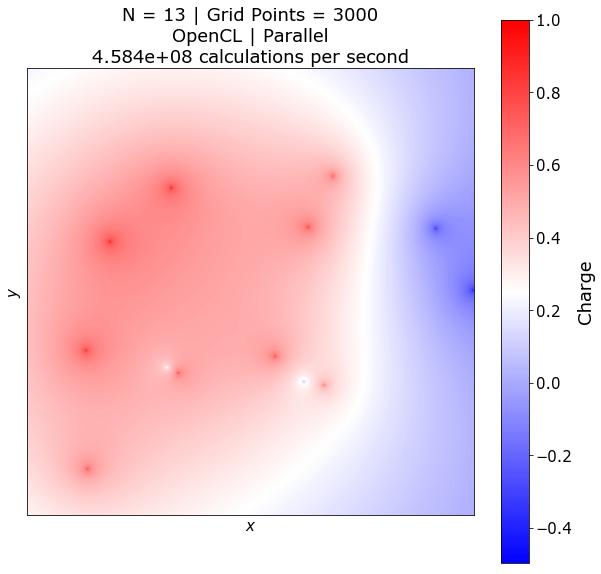

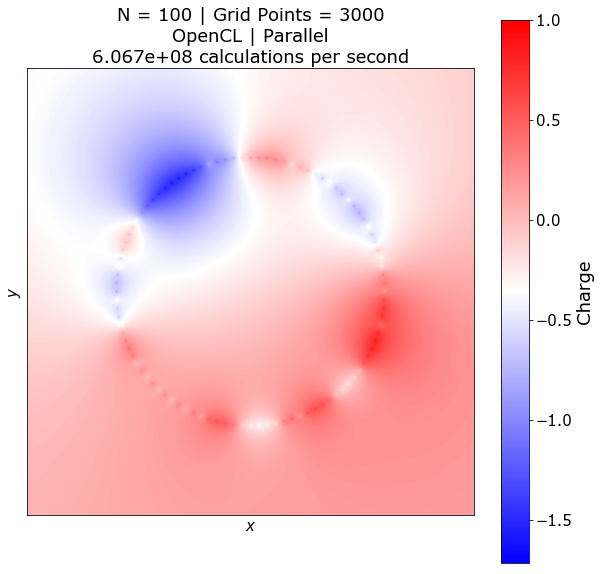

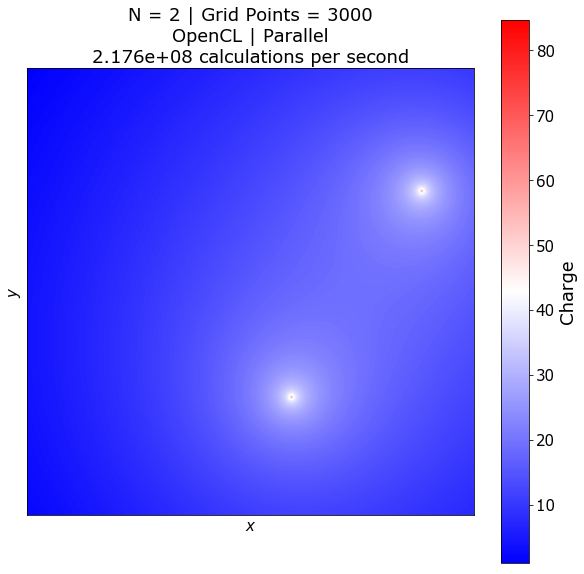

In [48]:
grid_2 = PotentialGrid(13, 3000, dtype='float64', circle=False, opencl=True,
                     parallel=True, random_charges=True)
grid_3 = PotentialGrid(100, 3000, dtype='float64', circle=True, opencl=True,
                     parallel=True, random_charges=True)
grid_4 = PotentialGrid(2, 3000, dtype='float64', circle=False, opencl=True,
                     parallel=True, random_charges=True)

grid_2.show_potential(plot_charges=False)
grid_3.show_potential(plot_charges=False)
grid_4.show_potential(plot_charges=False)

### Benchmarking: Part I

We shall use a circle of particles with a radius of 0.3, each with a charge of + 1. We shall examine how the number of charges and the resolution of the grid affect calculation time using all three methods.

In [10]:
def benchmark(N=[10], resolution=[100], use_python=True, use_series=True, use_doubles=True, trials=100, print_results=True):
    with Timer() as t:
        print_output=[]
        info=[]
        dtypes=['float32']
        if use_doubles:
            dtypes.append('float64')
        for n in N:
            for res in resolution:
                calculations=n*res**2
                for dtype in dtypes:
                    print_output.append(dtype + ' | Particles: ' + str(n) + ' | Resolution: ' + str(res) + ' | Calculations: ' +
                                        '%.3e' % (calculations))
                    print_output.append('-------------------------------------------------------------------------')
                    for opencl in [False, True]:
                        if opencl or (not opencl and use_python):
                            for parallel in [False, True]:
                                if not opencl and parallel:
                                    pass
                                elif not use_series and not parallel:
                                    pass
                                else:
                                    times=[]
                                    for trial in range(trials):
                                        times.append(PotentialGrid(n, res, dtype, circle=True, opencl=opencl, parallel=parallel,
                                                                  random_charges=False).startup_time)
                                    info.append([n, res, dtype, opencl, parallel, np.mean(times), calculations/np.mean(times)])
                                    print_output.append('   OpenCL: ' + str(opencl) + ',' + ' '*(6-len(str(opencl))) +
                                                        'Parallel: ' + str(parallel) + ',' + ' '*(6-len(str(parallel))) +
                                                        'Mean Potential Calculation Time (s): ' + str(np.mean(times))[:6] + ',' +
                                                        ' '*(7-len(str(np.mean(times))[:6])) + 'Calcs/s: ' + '%.3e' % (calculations/np.mean(times)))
                    print_output.append('   ')
    if print_results:
        for line in print_output:
            print(line)
        print('Benchmark time (s): ' + str(t.interval)[:6])
    return info

In [11]:
info=benchmark([10], [100], use_python=True, use_series=True, use_doubles=True, trials=10, print_results=True)

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x2620cfad6b0> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)


float32 | Particles: 10 | Resolution: 100 | Calculations: 1.000e+05
-------------------------------------------------------------------------
   OpenCL: False, Parallel: False, Mean Potential Calculation Time (s): 1.1877, Calcs/s: 8.420e+04
   OpenCL: True,  Parallel: False, Mean Potential Calculation Time (s): 0.0784, Calcs/s: 1.274e+06
   OpenCL: True,  Parallel: True,  Mean Potential Calculation Time (s): 0.0153, Calcs/s: 6.536e+06
   
float64 | Particles: 10 | Resolution: 100 | Calculations: 1.000e+05
-------------------------------------------------------------------------
   OpenCL: False, Parallel: False, Mean Potential Calculation Time (s): 1.1706, Calcs/s: 8.542e+04
   OpenCL: True,  Parallel: False, Mean Potential Calculation Time (s): 0.0785, Calcs/s: 1.274e+06
   OpenCL: True,  Parallel: True,  Mean Potential Calculation Time (s): 0.0143, Calcs/s: 6.949e+06
   
Benchmark time (s): 25.452


There is clearly a speed difference between the methods (as would be expected), but it cannot be truly appreciated until the grid size is increased significantly. From here, we will not use Python because it is prohibatively slow. Benchmarking will be between an OpenCL ```for``` loop (series) and OpenCL parallel. For speed, we will only use single precision:

In [12]:
info=benchmark([10], [1500], use_python=False, use_series=True, use_doubles=False, trials=10, print_results=True)

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x2620cfad6b0> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)


float32 | Particles: 10 | Resolution: 1500 | Calculations: 2.250e+07
-------------------------------------------------------------------------
   OpenCL: True,  Parallel: False, Mean Potential Calculation Time (s): 13.257, Calcs/s: 1.697e+06
   OpenCL: True,  Parallel: True,  Mean Potential Calculation Time (s): 0.0221, Calcs/s: 1.017e+09
   
Benchmark time (s): 132.82


To really appreciatate the increased performance offered by parallel programming, we must ramp up $N$ to 200 and the resolution to 10,000, increasing the calculations to 20 bn. Only the use of parallel OpenCL is feasible here:

In [13]:
info=benchmark([200], [10000], use_python=False, use_series=False, use_doubles=False, trials=4, print_results=True)

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x2620cfad6b0> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)


float32 | Particles: 200 | Resolution: 10000 | Calculations: 2.000e+10
-------------------------------------------------------------------------
   OpenCL: True,  Parallel: True,  Mean Potential Calculation Time (s): 4.2630, Calcs/s: 4.691e+09
   
Benchmark time (s): 17.230


On my Intel Graphics 620 with 24 compute units, the above calculation topped 4.8 bn calculations per second (cps). Compared to numpy (max: 90,000) and OpenCL in series (max: 1.7 million), the benifits of parallelism are obvious. Based on those numbers, it offers 2800 times greater cps.

Because of the architecture of the parallelism, the number of particles $N$ will affect the speed differently to the level of grid discretisation $M$. To explore this, we plot the mean calculation time as a function of first $M^2$ (so that we assess the number of grid points, not just the dimension) and then  $N$:

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x2620cfad6b0> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)


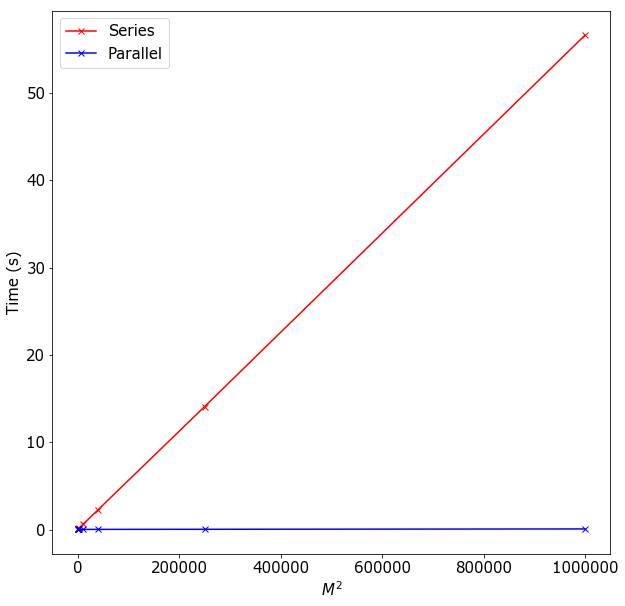

In [14]:
M = np.array([1, 5, 10, 50, 100, 200, 500, 1000])
s_times=[]
p_times=[]
for m in M:
    info = benchmark([100], [m], use_python=False, use_series=True, use_doubles=False,
                           trials=2, print_results=False)
    s_times.append(info[0][5])
    p_times.append(info[1][5])
    
font = {'family' : 'verdana',
        'weight' : 'normal',
        'size'   : 15}

rc('font', **font)
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
s = plt.plot(M**2, s_times, 'r-x', label='Series')
p = plt.plot(M**2, p_times, 'b-x', label='Parallel')
plt.xlabel(r'$M^2$')
plt.ylabel('Time (s)')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.show()

The relationship is linear in the number of grid points ($\mathcal{O}(M^2)$) in series and $\mathcal{O}(1)$ in parallel, at least up until $M^2$ exceeds the total number of possible concurrent threads. This is to be expected with the grid points calculated in parallel with particle interactions calculated in series. We can also plot the relationship between $N$ and calculation time. We must show them on different plots to better exhibit the relationships.

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x2620cfad6b0> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)


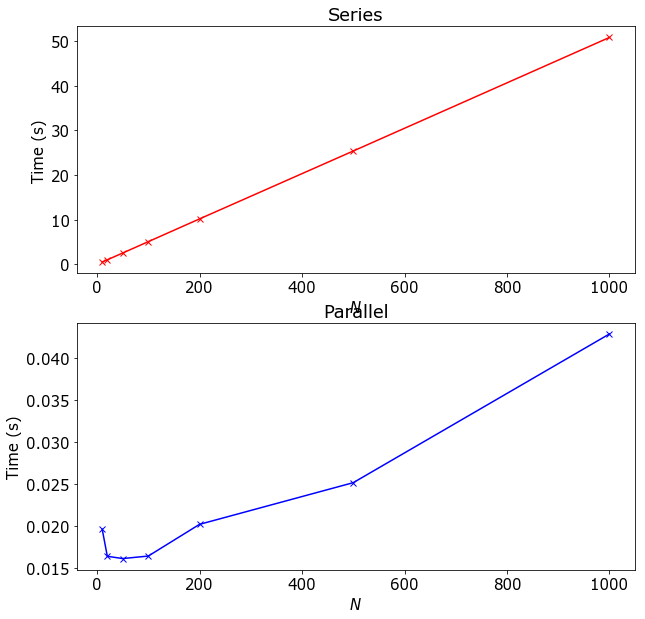

In [15]:
N = np.array([10, 20, 50, 100, 200, 500, 1000])
s_times=[]
p_times=[]
for n in N:
    info = benchmark([n], [300], use_python=False, use_series=True, use_doubles=False,
                           trials=3, print_results=False)
    s_times.append(info[0][5])
    p_times.append(info[1][5])
    
font = {'family' : 'verdana',
        'weight' : 'normal',
        'size'   : 15}

rc('font', **font)
plt.clf()
fig, (sax, pax) = plt.subplots(2, 1, figsize=(10, 10))
sax.plot(N, s_times, 'r-x')
pax.plot(N, p_times, 'b-x')
sax.set_title('Series')
pax.set_title('Parallel')
sax.set_xlabel(r'$N$')
sax.set_ylabel('Time (s)')
pax.set_xlabel(r'$N$')
pax.set_ylabel('Time (s)')
plt.show()

The following trillion-calculation benchmark took 213 seconds per trial (OpenCL, parallel):

In [49]:
benchmark([10000], [10000], use_python=False, use_series=False, use_doubles=False,
                           trials=3, print_results=True)

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x2620cfad6b0> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)


float32 | Particles: 10000 | Resolution: 10000 | Calculations: 1.000e+12
-------------------------------------------------------------------------
   OpenCL: True,  Parallel: True,  Mean Potential Calculation Time (s): 213.31, Calcs/s: 4.688e+09
   
Benchmark time (s): 640.16


[[10000, 10000, 'float32', True, True, 213.31965017318726, 4687800674.6595201]]

The relationships are both linear: $t = \mathcal{O}(N)$, albeit with vastly different absolute times. We can can also examine how the precision affects computation time in parallel:

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x2620cfad6b0> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)
C:\Users\Jack\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


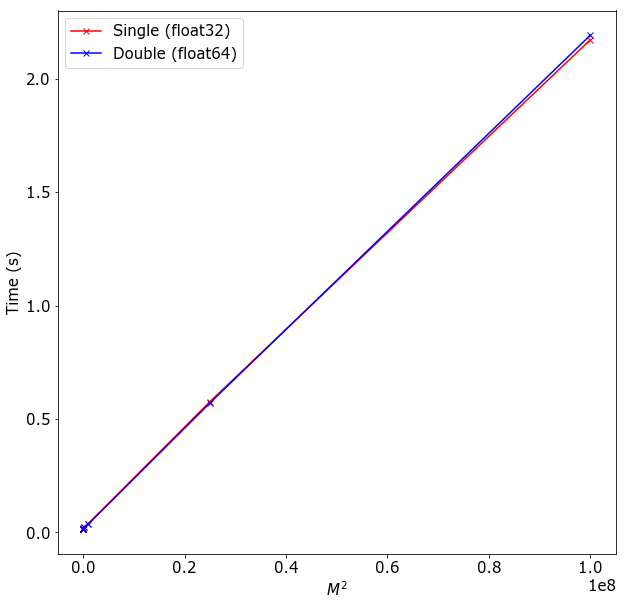

In [16]:
M = np.array([1, 5, 10, 50, 100, 200, 500, 1000, 5000, 10000])
sing_times=[]
doub_times=[]
for m in M:
    info = benchmark([100], [m], use_python=False, use_series=False, use_doubles=True,
                           trials=5, print_results=False)
    sing_times.append(info[0][5])
    doub_times.append(info[1][5])
    
font = {'family' : 'verdana',
        'weight' : 'normal',
        'size'   : 15}

rc('font', **font)
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
s = plt.plot(M**2, sing_times, 'r-x', label='Single (float32)')
d = plt.plot(M**2, doub_times, 'b-x', label='Double (float64)')
plt.xlabel(r'$M^2$')
plt.ylabel('Time (s)')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.show()

On my GPU, the difference was negligable.

### Plots: Part II

For animation, we define the ```dynamic``` function which uses ```matplotlib```'s ```animation.FuncAnimation``` class to create smooth animations, rendered to HTML5 by ```ffmpeg```. It takes many of the same parameters as the ```PotentialGrid``` constructor, along with a few others relating to the animation process. At each frame, the subfunction ```animate``` is called, which in turn calls the ```move``` method of ```PotentialGrid```.

The ```move``` method of ```PotentialGrid``` provides a way for the particles to move under the forces they exert on one another. Using the algorithm mentioned above, we can now step through at a timestep of our choosing (using the parameter ```detal_t``` which is passed to OpenCL or numpy). An example of such an animation can be seen below; the charges are chosen to be random because it makes for a more interesting picture:

In [9]:
def dynamic(N, resolution, dtype, circle, opencl, parallel, pparallel, time_step, frames, random_charges):
    grid = PotentialGrid(N, resolution, dtype=dtype, circle=circle, opencl=True,
                     parallel=parallel, device_id=0, random_charges=random_charges)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    v = abs(np.amax(grid.grid_arr))
    if random_charges:
        line = plt.imshow(np.zeros((grid.N, grid.N)), vmin=-v, vmax=v, cmap='bwr')
    else:
        line = plt.imshow(np.zeros((grid.N, grid.N)), vmin=0, vmax=v, cmap='bwr')
    cbar = plt.colorbar()
    cbar.set_label('Charge',size=18)
    
    def init():
        line.set_data(grid.grid_arr)
        return (line, )

    def animate(i):
        s = ' '*(5-len(str(i+1)))
        sys.stdout.write("\rCalculating step " + s + str(i+1) + ' of ' + str(frames))
        sys.stdout.flush()
        grid.move(time_step, opencl=opencl, parallel=parallel, pparallel=pparallel)
        line.set_array(grid.calculate_potential_grid())
        return(line, )

    
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=50, blit=True)
    return anim

In [17]:
HTML(dynamic(N=10, resolution=1000, dtype='float32', circle=True, opencl=True, parallel=True, pparallel=True,
             time_step=0.008, frames=80, random_charges=False).to_html5_video())

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


Calculating step    80 of 80

Many opposing charges can be placed close together for more interesting interactions:

In [20]:
HTML(dynamic(N=100, resolution=1000, dtype='float32', circle=True, opencl=True, parallel=True, pparallel=False,
             time_step=0.008, frames=130, random_charges=True).to_html5_video())

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


Calculating step   130 of 130

In [32]:
HTML(dynamic(N=100, resolution=1000, dtype='float32', circle=False, opencl=True, parallel=True,
             time_step=0.008, frames=200, random_charges=True).to_html5_video())

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x2620cfad6b0> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)


Calculating step   200 of 200

### Benchmarking: Part II

Because the calculation of the velocities and movement of a particle does not explicitly depend on the potential at each grid point, but on its position relative to the other particles, the parallelisation as implemented here should give an improvement of $N^2$ over calculations in series. Because the grid does not affect the movement calculations, we will minimise the effects of this by setting $M$ equal to 1 (we only want to measure how efficient the movement algorithm is).

In [206]:
grid_move_series = 1
grid_move_parallel = 1
grid_move_parallel = 1
s_times=[]
p_times=[]
pp_times=[]
grid_move_series = PotentialGrid(20, 1, dtype='float32', circle=True, opencl=True,
                     parallel=True, random_charges=True)
grid_move_parallel = PotentialGrid(20, 1, dtype='float32', circle=True, opencl=True,
                     parallel=True, random_charges=True)
grid_move_pparallel = PotentialGrid(20, 1, dtype='float32', circle=True, opencl=True,
                     parallel=True, random_charges=True)

for i in range(100):
    with Timer() as r:
        grid_move_series.move(0.0002, opencl=True, parallel=False, pparallel=False)
    s_times.append(r.interval)
    with Timer() as b:
        grid_move_parallel.move(0.0002, opencl=True, parallel=True, pparallel=False)
    p_times.append(b.interval)
    with Timer() as x:
        grid_move_pparallel.move(0.0002, opencl=True, parallel=True, pparallel=True)
    pp_times.append(x.interval)
    
print('Time per move (series) (s)  :', str(np.mean(s_times))[:6])
print('Time per move (parallel) (s):', str(np.mean(p_times))[:6])
print('Time per move (pparallel) (s):', str(np.mean(pp_times))[:6])

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


Time per move (series) (s)  : 0.0370
Time per move (parallel) (s): 0.0357
Time per move (pparallel) (s): 0.0345


There is no significant when $N$ is low; this is to be expected, as the parallelism is over the number of particles and the overheads of allocating threads removes any benifits. However, if we increase $N$, we see that the difference is significant:

In [4]:
grid_move_series = 1
grid_move_parallel = 1
grid_move_pparallel = 1
s_times=[]
p_times=[]
pp_times=[]
grid_move_series = PotentialGrid(3000, 1, dtype='float32', circle=True, opencl=True,
                     parallel=True, random_charges=True)
grid_move_parallel = PotentialGrid(3000, 1, dtype='float32', circle=True, opencl=True,
                     parallel=True, random_charges=True)
grid_move_pparallel = PotentialGrid(3000, 1, dtype='float32', circle=True, opencl=True,
                     parallel=True, random_charges=True)

for i in range(100):
    #with Timer() as r:
    #    grid_move_series.move(0.0002, opencl=True, parallel=False, pparallel=False)
    #s_times.append(r.interval)
    with Timer() as b:
        grid_move_parallel.move(0.0002, opencl=True, parallel=True, pparallel=False)
    p_times.append(b.interval)
    with Timer() as b:
        grid_move_pparallel.move(0.0002, opencl=True, parallel=True, pparallel=True)
    pp_times.append(b.interval)
    
#print('Time per move (series) (s)  :', str(np.mean(s_times))[:6])
print('Time per move (parallel) (s):', str(np.mean(p_times))[:6])
print('Time per move (pparallel) (s):', str(np.mean(pp_times))[:6])

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


Time per move (parallel) (s): 0.0545
Time per move (pparallel) (s): 0.2087


The difference is now clear; on my GPU, the time per move in series was 2.63s vs 0.055s in parallel - 48 times faster.

We could also check to see what affect the time steps have on the movement of the particles. Using the same configuration to begin, we set the time step variously to 0.001, 0.005, 0.01 and 0.015:

In [36]:
HTML(dynamic(N=6, resolution=500, dtype='float32', circle=True, opencl=True, parallel=True,
             time_step=0.001, frames=480, random_charges=False).to_html5_video())

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x2620cfad6b0> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)


Calculating step   480 of 480

In [37]:
HTML(dynamic(N=6, resolution=500, dtype='float32', circle=True, opencl=True, parallel=True,
             time_step=0.005, frames=96, random_charges=False).to_html5_video())

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x2620cfad6b0> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)


Calculating step    96 of 96

In [38]:
HTML(dynamic(N=6, resolution=500, dtype='float32', circle=True, opencl=True, parallel=True,
             time_step=0.01, frames=48, random_charges=False).to_html5_video())

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x2620cfad6b0> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)
C:\Users\Jack\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Calculating step    48 of 48

In [39]:
HTML(dynamic(N=6, resolution=500, dtype='float32', circle=True, opencl=True, parallel=True,
             time_step=0.015, frames=32, random_charges=False).to_html5_video())

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x2620cfad6b0> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)
C:\Users\Jack\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Calculating step    32 of 32

Aside from the difference in movement speed - caused by a constant frame interval with varying time steps rather than 'faster' movement - there is not much difference. However, this may be because of the symmetry of the situation of the setup.